In [54]:
import xarray as xr
import xwmb
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [55]:
labels = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)", "i)"]
kwargs = {"units":r"10$^{9}$ kg/s", "alpha":0.7, "lw":1.5}

In [56]:
## Sign corrections and variable renamings
def sign_corrections(wmt):
    wmt = wmt.rename_vars({
        "Leibniz_material_derivative": "realized_transformation",
        "kinematic_material_derivative": "kinematic_transformation",
        "process_material_derivative": "material_transformation"
    })
    mass_budget_vars = [
        "thermo_hist", "mass_tendency", "mass_bounds", "mass_source", "layer_mass", "convergent_mass_transport"
    ]
    

    for v in wmt.data_vars:
        if v not in mass_budget_vars:
            wmt[v] = -1*wmt[v]
    return wmt

## DELETE THIS CELL IF CALCULATIONS ARE RE-RUN USING NEWER VERSIONS OF XWMT and XWMB

In [57]:
import matplotlib.pyplot as plt

def hovmoller(wmt, var, robust=False, units="kg", **kwargs):
    da = wmt[var]
    if robust:
        vmax = np.abs(da).quantile(0.95).compute()
        kwargs["vmin"] = -vmax
        kwargs["vmax"] = vmax

    coord_bounds = wmt[[c for c in wmt.coords if "i_target" in c][0]]
    time_idx_bounds = xr.DataArray(np.arange(0, wmt.time_bounds.size), dims=('time_bounds',))
    pc = plt.pcolor(
        time_idx_bounds,
        coord_bounds,
        da.transpose() if da.dims[0] == "time" else da,
        **kwargs
    )

    dtick = da.time.size//12
    date_str = [f"{d.year}-{str(d.month).zfill(2)}-{str(d.day).zfill(2)}" for d in wmt["time_bounds"].values[::dtick]]
    plt.xticks(time_idx_bounds[::dtick], date_str, rotation=90)
    plt.colorbar(label=f"transformation rate [{units}]")
    for coord_bound in coord_bounds:
        plt.axhline(coord_bound, color="k", lw=0.25)
    
    return pc

def stairs(wmt, var, units="kg/s", **kwargs):
    da = wmt[var]
    coord = wmt[[c for c in wmt.coords if "l_target" in c][0]]
    coord_bounds = wmt[[c for c in wmt.coords if "i_target" in c][0]]
    l = plt.stairs(da, coord_bounds, **kwargs, orientation="horizontal")
    plt.xlabel(f"WMT rate [{units}]")
    return l

In [ ]:
wmt_onlinediagbins.sigma2_i_target

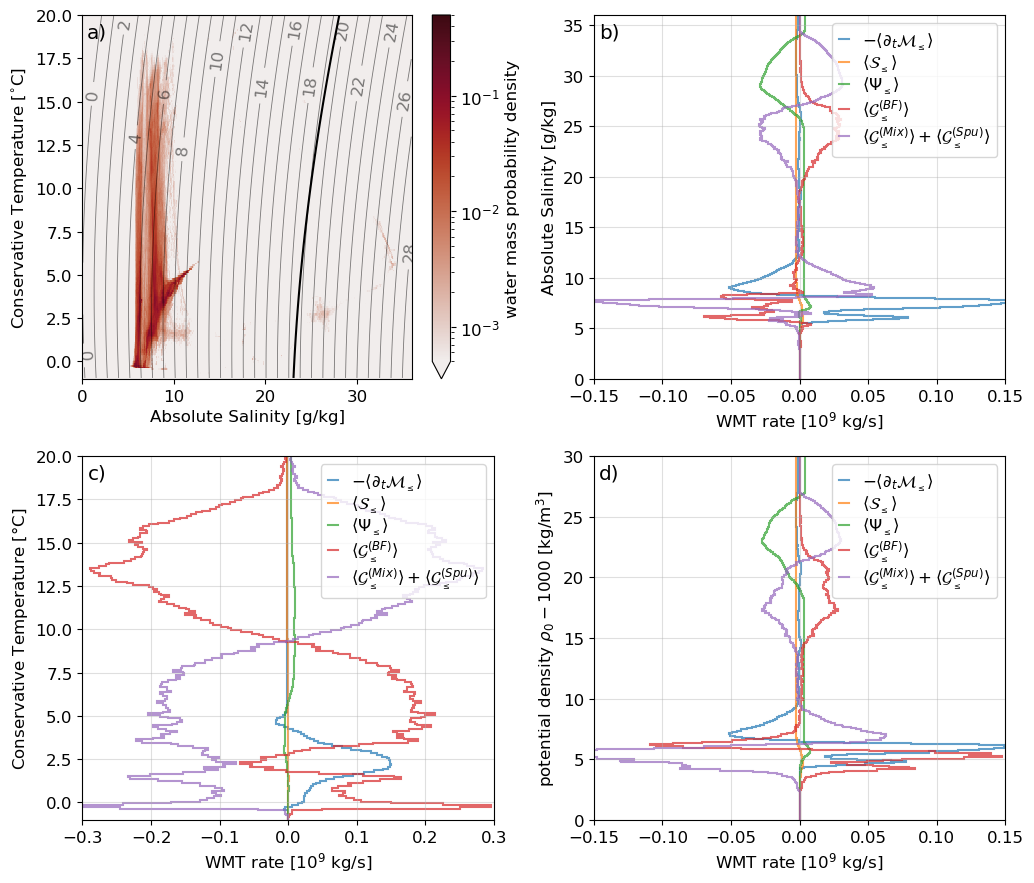

In [70]:
import matplotlib.colors as colors
import cmocean
import gsw
import numpy as np

ylims = {"salt": (0, 36), "heat": (-1, 20), "sigma0": (0, 30)}
ylabels = {"salt": "Absolute Salinity [g/kg]", "heat": r"Conservative Temperature [$\degree$C]", "sigma0": r"potential density $\rho_{0} - 1000$ [kg/m$^{3}$]"}

fig, axes = plt.subplots(2,2,figsize=(10.5,9))

wmt = xr.open_dataset(f"data/baltic_wmb_sigma0_natv_hourly.nc")
wmt = sign_corrections(wmt)

i=0
σ0 = gsw.sigma0(wmt.sa_bin, wmt.ct_bin)
σ2 = gsw.sigma2(wmt.sa_bin, wmt.ct_bin)

ax = axes.flatten()[i]
plt.sca(ax)
pc = wmt.thermo_hist.where(wmt.thermo_hist!=0, 1.e-12).plot(norm=colors.LogNorm(vmin=5.e-4, vmax=5.e-1), x="sa_bin", cmap=cmocean.cm.amp)
pc.colorbar.set_label("water mass probability density")
plt.xlim(ylims["salt"])
plt.ylim(ylims["heat"])

pc = σ0.sel(sa_bin=slice(*ylims["salt"]), ct_bin=slice(*ylims["heat"])).plot.contour(ax=ax, levels=np.arange(0., 30, 1), x="sa_bin", colors="k", linewidths=0.6, alpha=0.5)
ax.clabel(pc, pc.levels[::2], inline=True, fontsize=12)

wmt_onlinediagbins = xr.open_dataset(f"data/baltic_wmb_sigma2-online-diagbins_rho2_hourly.nc")
pc = σ2.sel(sa_bin=slice(*ylims["salt"]), ct_bin=slice(*ylims["heat"])).plot.contour(
    ax=ax,
    linestyles="-",
    levels=wmt_onlinediagbins.sigma2_i_target[[1]],
    x="sa_bin", colors="k", linewidths=1.5, alpha=1
)

plt.xlabel("Absolute Salinity [g/kg]")
plt.ylabel(r"Conservative Temperature [$^{\circ}$C]")
plt.title(f"{labels[i]}", y=0.915, x=0.0125, loc="left")

for i, lam in enumerate(["salt", "heat", "sigma0"], start=1):
    wmt = xr.open_dataset(f"data/baltic_wmb_{lam}_natv_hourly.nc")
    wmt = sign_corrections(wmt)
    
    wmt_mean = wmt.mean('time')*1e-9
    wmt_mean["diffusion_both"] = wmt_mean.diffusion + wmt_mean.spurious_numerical_mixing
        
    ax = axes.flatten()[i]
    plt.sca(ax)
    stairs(-wmt_mean, 'mass_tendency',             label=r"$-\langle \partial_{t} \mathcal{M}_{_{\leq}} \rangle$",**kwargs)
    stairs( wmt_mean, 'mass_source',               label=r"$\langle \mathcal{S}_{_{\leq}} \rangle$",            **kwargs)
    stairs( wmt_mean, 'convergent_mass_transport', label=r"$\langle \Psi_{_{\leq}} \rangle$",     **kwargs)
    stairs( wmt_mean, 'boundary_fluxes',           label=r"$\langle \mathcal{G}_{_{\leq}}^{(BF)} \rangle$",      **kwargs)
    label = r"$\langle \mathcal{G}_{_{\leq}}^{(Mix)}\rangle + \langle \mathcal{G}_{_{\leq}}^{(Spu)} \rangle$"
    stairs( wmt_mean, 'diffusion_both',            label=label,     **kwargs)
    plt.ylabel(ylabels[lam]);
    
    if i>=1:
        plt.legend(handlelength=0.6, labelspacing=0.05, loc="upper right")
        
    plt.grid(True, alpha=0.4)
    plt.ylim(ylims[lam]);
    if lam=="heat":
        plt.xlim(-0.3, 0.3)
    else:
        plt.xlim(-0.15, 0.15)
    plt.title(f"{labels[i]}", y=0.915, x=0.0125, loc="left")

plt.tight_layout()
plt.savefig("figures/offline_budgets_temperature_salinity_density.png", bbox_inches="tight", dpi=250)

In [67]:
wmt_onlinediagbins.sigma2_i_target

<xarray.DataArray 'sigma2_i_target' (sigma2_i_target: 36)> Size: 288B
array([-0.5     , 28.      , 29.      , 29.484375, 29.953125, 30.40625 ,
       30.84375 , 31.265625, 31.671875, 32.0625  , 32.4375  , 32.796875,
       33.140625, 33.46875 , 33.78125 , 34.078125, 34.359375, 34.625   ,
       34.875   , 35.109375, 35.328125, 35.53125 , 35.71875 , 35.890625,
       36.046875, 36.1875  , 36.3125  , 36.4375  , 36.5625  , 36.6875  ,
       36.8125  , 36.9375  , 37.0625  , 37.1875  , 37.3125  , 38.      ])
Coordinates:
    rho2_i           (sigma2_i_target) float64 288B ...
  * sigma2_i_target  (sigma2_i_target) float64 288B -0.5 28.0 ... 37.31 38.0

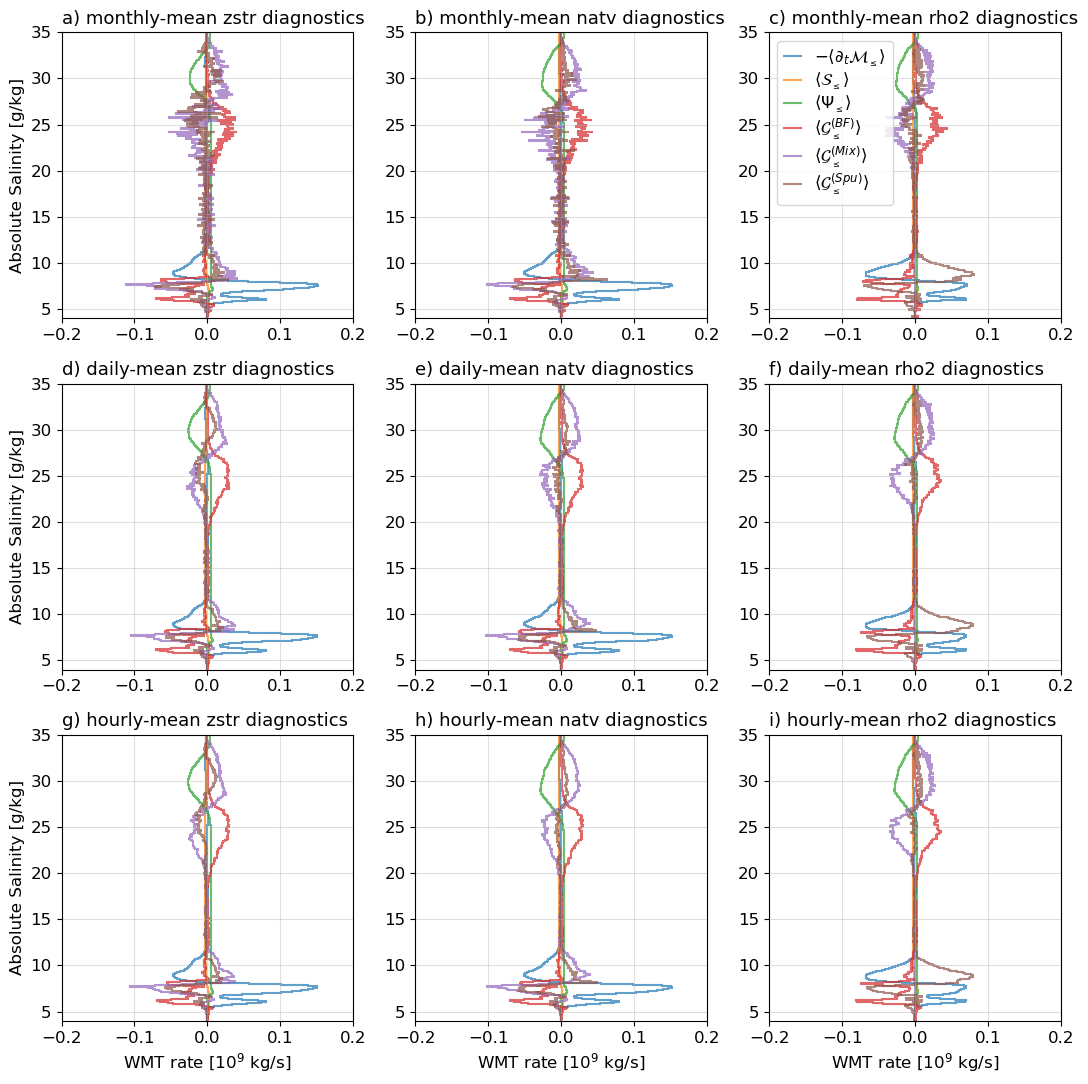

In [59]:
fig, axes = plt.subplots(3,3,figsize=(11,11))
i = 0
for dt in ["monthly", "daily", "hourly"]:
    for gridname in ["zstr", "natv", "rho2"]:
        wmt = xr.open_dataset(f"data/baltic_wmb_salt_{gridname}_{dt}.nc")
        wmt = sign_corrections(wmt)
        
        wmt_mean = wmt.mean('time')*1e-9
        
        ax = axes.flatten()[i]
        plt.sca(ax)
        stairs(-wmt_mean, 'mass_tendency',             label=r"$-\langle \partial_{t} \mathcal{M}_{_{\leq}} \rangle$",**kwargs)
        stairs( wmt_mean, 'mass_source',               label=r"$\langle \mathcal{S}_{_{\leq}} \rangle$",            **kwargs)
        stairs( wmt_mean, 'convergent_mass_transport', label=r"$\langle \Psi_{_{\leq}} \rangle$",                   **kwargs)
        stairs( wmt_mean, 'boundary_fluxes',           label=r"$\langle \mathcal{G}_{_{\leq}}^{(BF)} \rangle$",      **kwargs)
        stairs( wmt_mean, 'diffusion',                 label=r"$\langle \mathcal{G}_{_{\leq}}^{(Mix)} \rangle$",     **kwargs)
        stairs( wmt_mean, 'spurious_numerical_mixing', label=r"$\langle \mathcal{G}_{_{\leq}}^{(Spu)} \rangle$", **kwargs)
        plt.ylabel(ylabels["salt"]);

        if i==2:
            plt.legend(loc="upper left", handlelength=1., labelspacing=0.09)
        if gridname != "zstr":
            plt.ylabel("")
        if dt != "hourly":
            plt.xlabel("")
        plt.grid(True, alpha=0.4)
        plt.title(f"{labels[i]} {dt}-mean {gridname} diagnostics", loc="left", fontsize=13)
        plt.title("")
        plt.ylim(4, 35);
        plt.xlim(-0.2, 0.2)
        i+=1
plt.tight_layout()
plt.savefig("figures/offline_budget_convergence_salt.png", bbox_inches="tight", dpi=250)

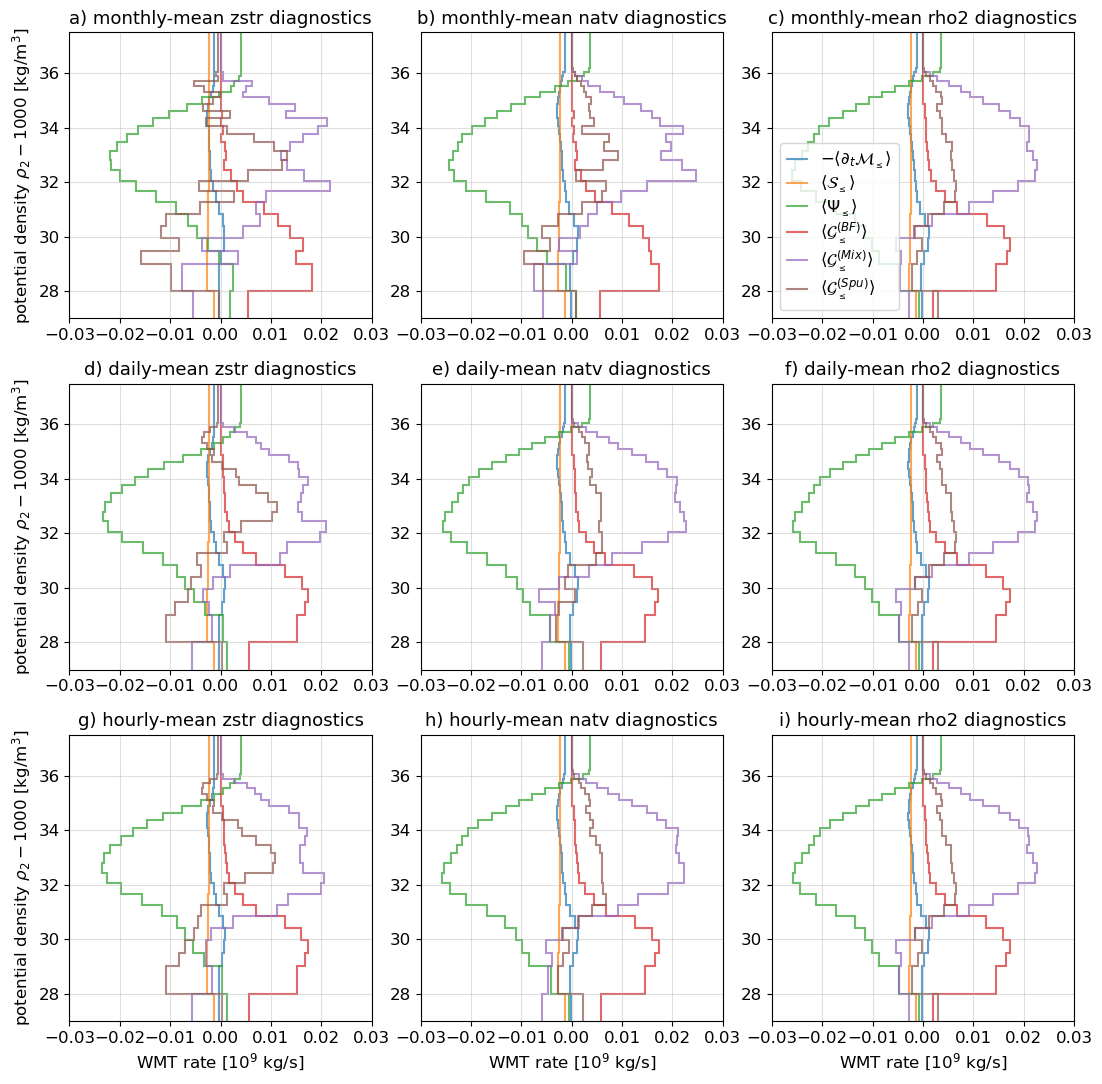

In [60]:
fig, axes = plt.subplots(3,3,figsize=(11,11))
i = 0
for dt in ["monthly", "daily", "hourly"]:
    for gridname in ["zstr", "natv", "rho2"]:
        wmt = xr.open_dataset(f"data/baltic_wmb_sigma2-online-diagbins_{gridname}_{dt}.nc")
        wmt = sign_corrections(wmt)
        
        wmt_mean = wmt.mean('time')*1e-9
        
        ax = axes.flatten()[i]
        plt.sca(ax)
        stairs(-wmt_mean, 'mass_tendency',             label=r"$-\langle \partial_{t} \mathcal{M}_{_{\leq}}\rangle$",**kwargs)
        stairs( wmt_mean, 'mass_source',               label=r"$\langle \mathcal{S}_{_{\leq}}\rangle$",            **kwargs)
        stairs( wmt_mean, 'convergent_mass_transport', label=r"$\langle \Psi_{_{\leq}}\rangle$",                   **kwargs)
        stairs( wmt_mean, 'boundary_fluxes',           label=r"$\langle \mathcal{G}_{_{\leq}}^{(BF)}\rangle$",      **kwargs)
        stairs( wmt_mean, 'diffusion',                 label=r"$\langle \mathcal{G}_{_{\leq}}^{(Mix)}\rangle$",     **kwargs)
        stairs( wmt_mean, 'spurious_numerical_mixing', label=r"$\langle \mathcal{G}_{_{\leq}}^{(Spu)} \rangle$", **kwargs)
        plt.ylabel(r"potential density $\rho_{2} - 1000$ [kg/m$^{3}$]");

        if i==2:
            plt.legend(loc="lower left", handlelength=1.2, labelspacing=0.12)
        if gridname != "zstr":
            plt.ylabel("")
        if dt != "hourly":
            plt.xlabel("")
        plt.grid(True, alpha=0.4)
        plt.title(f"{labels[i]} {dt}-mean {gridname} diagnostics", fontsize=13)
        plt.ylim(27, 37.5);
        plt.xlim(-0.03, 0.03)
        i+=1
plt.tight_layout()
plt.savefig("figures/offline_budget_convergence_sigma2-online-diagbins.png", bbox_inches="tight", dpi=250)

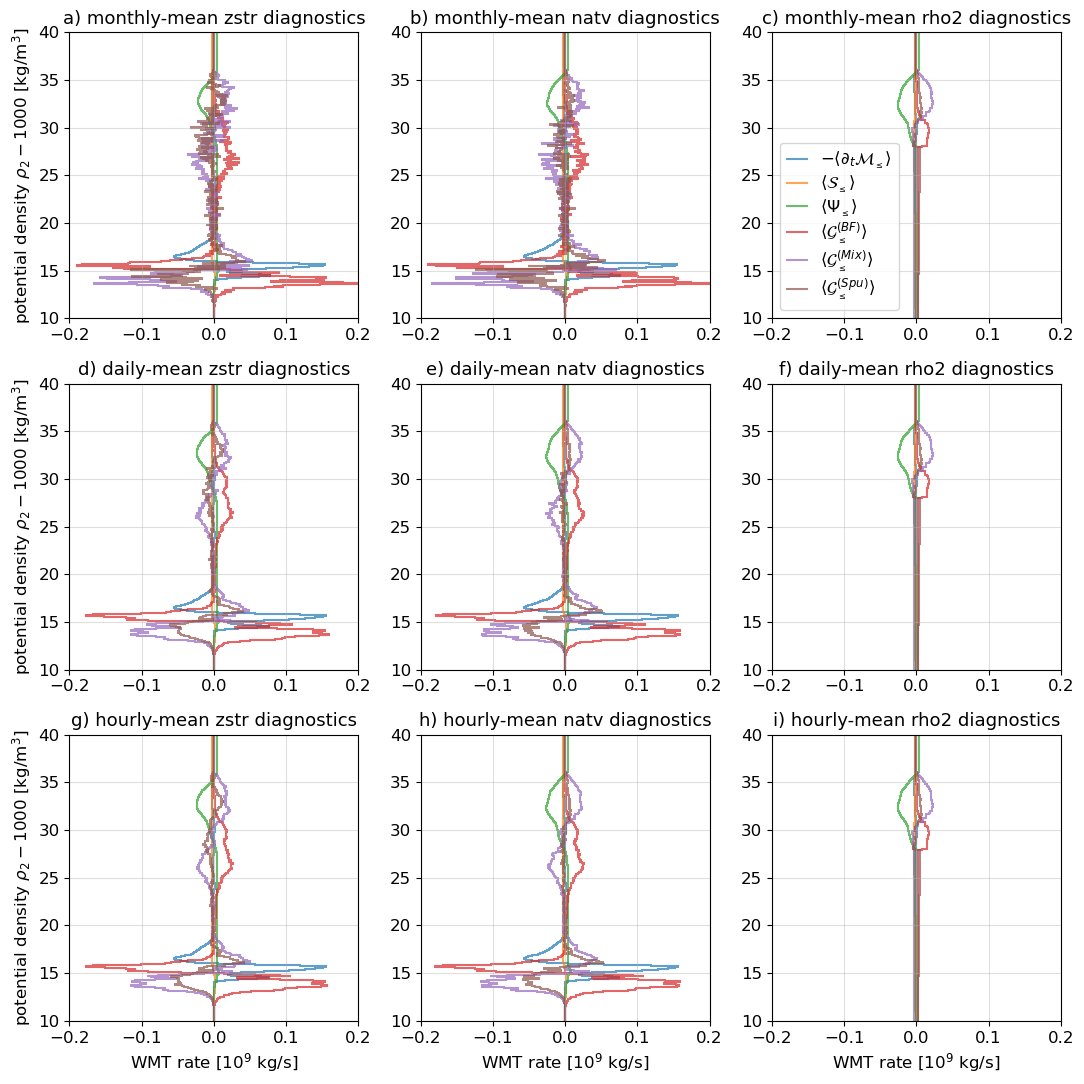

In [61]:
fig, axes = plt.subplots(3,3,figsize=(11,11))
i = 0
for dt in ["monthly", "daily", "hourly"]:
    for gridname in ["zstr", "natv", "rho2"]:
        wmt = xr.open_dataset(f"data/baltic_wmb_sigma2-online_{gridname}_{dt}.nc")
        wmt = sign_corrections(wmt)
        
        wmt_mean = wmt.mean('time')*1e-9
        
        ax = axes.flatten()[i]
        plt.sca(ax)
        stairs(-wmt_mean, 'mass_tendency',             label=r"$-\langle \partial_{t} \mathcal{M}_{_{\leq}} \rangle$",**kwargs)
        stairs( wmt_mean, 'mass_source',               label=r"$\langle \mathcal{S}_{_{\leq}} \rangle$",            **kwargs)
        stairs( wmt_mean, 'convergent_mass_transport', label=r"$\langle \Psi_{_{\leq}} \rangle$",                   **kwargs)
        stairs( wmt_mean, 'boundary_fluxes',           label=r"$\langle \mathcal{G}_{_{\leq}}^{(BF)} \rangle$",      **kwargs)
        stairs( wmt_mean, 'diffusion',                 label=r"$\langle \mathcal{G}_{_{\leq}}^{(Mix)} \rangle$",     **kwargs)
        stairs( wmt_mean, 'spurious_numerical_mixing', label=r"$\langle \mathcal{G}_{_{\leq}}^{(Spu)} \rangle$", **kwargs)
        plt.ylabel(r"potential density $\rho_{2} - 1000$ [kg/m$^{3}$]");

        if i==2:
            plt.legend(loc="lower left", handlelength=1.2, labelspacing=0.12)
        if gridname != "zstr":
            plt.ylabel("")
        if dt != "hourly":
            plt.xlabel("")
        plt.grid(True, alpha=0.4)
        plt.title(f"{labels[i]} {dt}-mean {gridname} diagnostics", fontsize=13)
        plt.ylim(10, 40);
        plt.xlim(-0.2, 0.2)
        i+=1
plt.tight_layout()
plt.savefig("figures/offline_budget_convergence_sigma2-online.png", bbox_inches="tight", dpi=250)